# 05. Scaling Laws

> ⚡Compute Note: I recommend running this notebook on a node with 1x H200 GPU. 

In this notebook, we'll explore the fascinating world of scaling laws for Large Language Models (LLMs). Scaling laws are empirical relationships that describe how a model's performance changes as we scale up its size, the amount of data it's trained on, or the computational budget.

We will focus on two main areas:
1.  **Data Scaling**: How much data do we need to train a model of a certain size? We'll start with the "Chinchilla" scaling law.
2.  **Hyperparameter Scaling**: How do we choose optimal hyperparameters like batch size and learning rate as we scale? We'll use an isoflop analysis, inspired by the methodology from papers like DeepSeek, to investigate this.

I highly recommend watching [Stanford CS336 on Scaling Laws](https://www.youtube.com/watch?v=6Q-ESEmDf4Q&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=9).

## 1. Data Scaling: The Chinchilla Rule

The [Chinchilla paper](https://arxiv.org/pdf/2203.15556) from DeepMind (2022) made a significant finding: for optimal performance at a given compute budget, model size and the number of training tokens should be scaled equally. They found that the best-performing models were trained on approximately **20 tokens for every parameter** in the model.

This gives us a simple rule of thumb to estimate the amount of training data we need for a model of a given size.

Let's formalize this and visualize the relationship.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

def chinchilla_data_scaling(num_params):
    """
    Calculates the recommended number of training tokens based on the Chinchilla scaling law.
    
    Args:
        num_params (int): The number of parameters in the model.
        
    Returns:
        int: The recommended number of training tokens.
    """
    return 20 * num_params

# Let's test it for a few model sizes
params_1m = 1_000_000
params_1b = 1_000_000_000
params_7b = 7_000_000_000

tokens_1m = chinchilla_data_scaling(params_1m)
tokens_1b = chinchilla_data_scaling(params_1b)
tokens_7b = chinchilla_data_scaling(params_7b)

print(f"Model with 1M parameters should be trained on ~{tokens_1m / 1e9:.2f} billion tokens.")
print(f"Model with 1B parameters should be trained on ~{tokens_1b / 1e9:.2f} billion tokens.")
print(f"Model with 7B parameters should be trained on ~{tokens_7b / 1e9:.2f} billion tokens.")

Model with 1M parameters should be trained on ~0.02 billion tokens.
Model with 1B parameters should be trained on ~20.00 billion tokens.
Model with 7B parameters should be trained on ~140.00 billion tokens.


Now, let's plot this relationship to get a better visual understanding. We'll use a log-log scale, which is standard for visualizing scaling laws as they often follow power-law relationships (straight lines on a log-log plot).

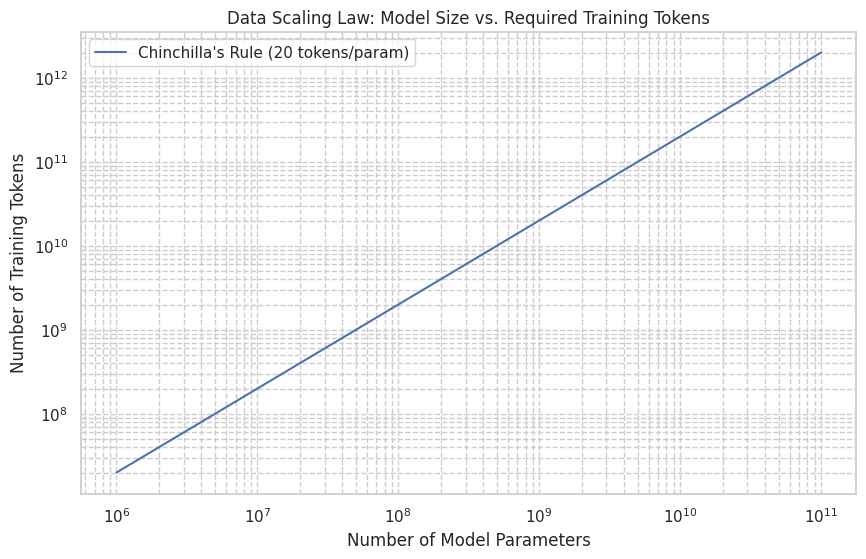

In [2]:
# Create a range of model sizes from 1M to 100B parameters
param_sizes = np.logspace(6, 11, num=100) # 10^6 to 10^11
required_tokens = [chinchilla_data_scaling(p) for p in param_sizes]

plt.figure(figsize=(10, 6))
plt.loglog(param_sizes, required_tokens, label="Chinchilla's Rule (20 tokens/param)")
plt.title("Data Scaling Law: Model Size vs. Required Training Tokens")
plt.xlabel("Number of Model Parameters")
plt.ylabel("Number of Training Tokens")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

## 2. Hyperparameter Scaling: Isoflop Analysis

Choosing the right hyperparameters (like learning rate and batch size) is crucial for efficient training. But how do the optimal values for these hyperparameters change as we scale our models and compute?

An **isoflop analysis** is a powerful technique to answer this. The core idea is to fix the total computational budget (measured in FLOPs - Floating Point Operations) and then run a series of experiments with different hyperparameter configurations to see which one achieves the lowest validation loss for that fixed budget.

This is exactly the methodology used in the DeepSeek paper to determine their learning rate and batch size schedules. They found that for a fixed compute budget, there's an optimal batch size and learning rate, and this optimum shifts as the compute budget changes.

### The Isoflop Contour Plot

The goal is to create a plot where:
- The x-axis is the Batch Size.
- The y-axis is the Learning Rate.
- The color/contour lines represent the final validation loss.

By looking at the "valley" in this contour plot, we can identify the combination of batch size and learning rate that is optimal for a given amount of compute.

### Our Experiment Setup

Actually running a full isoflop analysis is computationally very expensive, as it requires training dozens of models. For this notebook, we will simulate the *results* of such an analysis to demonstrate the concept. We'll generate data that mimics the typical shape of an isoflop contour plot.

We'll assume we ran an experiment for a model of a certain size, with a fixed compute budget of `C` FLOPs. We tried various batch sizes and learning rates and recorded the final validation loss for each run.

In [3]:
# Simulate the results of an isoflop analysis

# Define the hyperparameter ranges
batch_sizes = np.logspace(np.log2(512), np.log2(8192), num=10, base=2).astype(int)
learning_rates = np.logspace(-5, -3, num=10)

# Create a meshgrid for plotting
B, LR = np.meshgrid(batch_sizes, learning_rates)

# --- SIMULATED LOSS CALCULATION ---
# This function is a placeholder to generate a plausible-looking loss surface.
# In a real experiment, this would be the measured validation loss from a training run.
# The shape is designed to have a "valley" at an optimal point.
def simulate_loss(batch_size, learning_rate):
    # Let's assume the optimal point for this compute budget is around:
    # Batch Size = 2048, LR = 1e-4
    optimal_bs = 2048
    optimal_lr = 1.5e-4
    
    # Calculate loss based on distance from the optimum in log space
    log_bs_dist = (np.log(batch_size) - np.log(optimal_bs))**2
    log_lr_dist = (np.log(learning_rate) - np.log(optimal_lr))**2
    
    # A base loss and penalties for being non-optimal
    base_loss = 2.5
    loss = base_loss + 0.1 * log_bs_dist + 0.5 * log_lr_dist
    
    # Add some noise to make it look more realistic
    loss *= (1 + 0.05 * np.random.randn())
    
    return loss

# Generate the loss values for each combination of hyperparameters
losses = np.zeros_like(B, dtype=float)
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        losses[i, j] = simulate_loss(B[i, j], LR[i, j])

# Find the minimum loss and its corresponding hyperparameters
min_loss_val = np.min(losses)
min_idx = np.unravel_index(np.argmin(losses), losses.shape)
optimal_lr_found = LR[min_idx]
optimal_bs_found = B[min_idx]

print(f"Simulated Optimal Point:")
print(f"  - Batch Size: {optimal_bs_found}")
print(f"  - Learning Rate: {optimal_lr_found:.2e}")
print(f"  - Achieved Loss: {min_loss_val:.3f}")

Simulated Optimal Point:
  - Batch Size: 1755
  - Learning Rate: 2.15e-04
  - Achieved Loss: 2.275


### Visualizing the Isoflop Contours

Now, let's create the log-log contour plot. This visualization is key to understanding the relationship between batch size, learning rate, and model performance for a fixed compute budget. The "sweet spot" will be the dark, low-loss region.

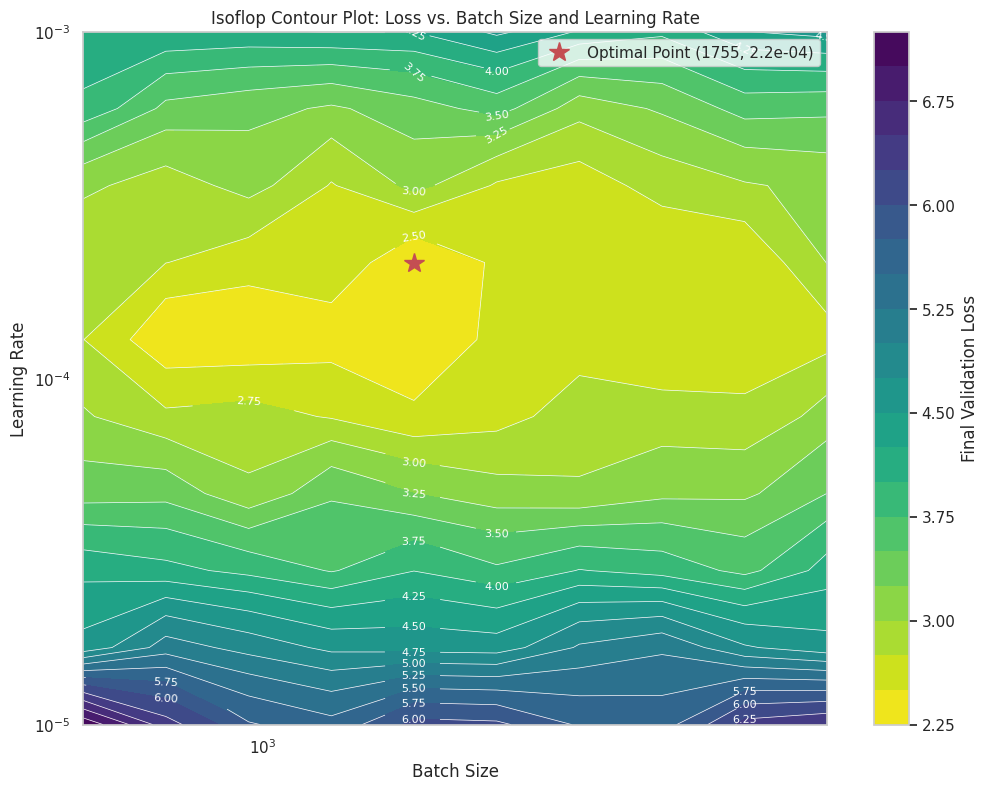

In [4]:
plt.figure(figsize=(12, 9))

# Create the contour plot
contour = plt.contourf(B, LR, losses, levels=20, cmap='viridis_r')
plt.colorbar(contour, label='Final Validation Loss')

# Add contour lines
contour_lines = plt.contour(B, LR, losses, levels=contour.levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')

# Mark the optimal point
plt.plot(optimal_bs_found, optimal_lr_found, 'r*', markersize=15, label=f'Optimal Point ({optimal_bs_found}, {optimal_lr_found:.1e})')

# Set log scales
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.title('Isoflop Contour Plot: Loss vs. Batch Size and Learning Rate')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Interpreting the Plot and Next Steps

The plot above is a powerful tool. It shows us that for a fixed computational budget:
- **If the batch size is too small or too large**, the performance degrades (loss increases).
- **If the learning rate is too low or too high**, the performance also degrades.
- There is an optimal region (the dark valley) where the combination of batch size and learning rate yields the best performance.

**How would we use this in practice?**

1.  **Choose a few compute budgets** (e.g., 1e18 FLOPs, 1e19 FLOPs, 1e20 FLOPs).
2.  **For each budget**, run a grid search over batch size and learning rate, training each model for that exact number of FLOPs.
3.  **Create an isoflop plot** for each compute budget.
4.  **Find the optimal (batch size, learning rate) pair** for each budget.
5.  **Plot the optimal hyperparameters against the compute budget**. This would give you a scaling law for your hyperparameters! For example, you might find that the optimal batch size grows as a power of the compute budget.

This empirical approach, while expensive, is how research labs derive the robust hyperparameter scaling laws that allow them to train massive models like GPT-4, Llama, and DeepSeek efficiently.


## 3. Scaling the Isoflop Analysis

The previous section showed how to find the optimal hyperparameters for a *single* model size and compute budget. But how do these optimal hyperparameters change as we scale the model itself?

To find this out, we need to repeat the isoflop analysis for several different model sizes. By tracking how the "optimal point" (the best batch size and learning rate) moves as the model size increases, we can derive a scaling law for the hyperparameters themselves.

### Simulating the Multi-Model Experiment

Once again, we'll simulate the results. We'll pretend we ran the analysis for three different model sizes:
- A small model (e.g., 10M parameters)
- A medium model (e.g., 100M parameters)
- A larger model (e.g., 1B parameters)

For each of these, we'll generate a loss landscape and find its optimal point. We'll design the simulation so that the optimal batch size tends to increase with model size, which is a common finding in scaling law research.


In [5]:
import torch
import tiktoken
from src.shraygpt import ShrayGPT
from lightning.fabric.utilities import measure_flops

tokenizer = tiktoken.get_encoding("r50k_base")

def get_total_param_count(module):
    return sum(p.numel() for p in module.parameters())

configs = {
    "Small": {
        "d_model": 64, "n_head": 8, "n_layers": 4,
        "num_experts": 4, "num_experts_per_tok": 1
    },
    "Medium": {
        "d_model": 512, "n_head": 16, "n_layers": 4,
        "num_experts": 8, "num_experts_per_tok": 1
    },
    "Large": {
        "d_model": 1024, "n_head": 32, "n_layers": 12,
        "num_experts": 8, "num_experts_per_tok": 2
    }
}

models = {}
for type, config in configs.items():
    model = ShrayGPT(
        vocab_size=tokenizer.n_vocab, 
        block_size=1024, 
        d_model=config['d_model'], 
        n_head=config['n_head'], 
        d_head=config['d_model'] // config['n_head'], 
        n_layers=config['n_layers'], 
        num_experts=config['num_experts'], 
        num_experts_per_tok=config['num_experts_per_tok']
    )
    models[type] = model
    param_count = get_total_param_count(model)
    print(f"{type} Model has {param_count:,} parameters.")

# Measure FLOPs for a single forward pass
flops_data = {}
for size, model in models.items():
    model_fwd = lambda: model(torch.zeros((1, 1024), dtype=torch.long))
    flops = measure_flops(model, model_fwd)
    flops_data[size] = flops
    print(f"{size} Model single forward pass FLOPs: {flops:.2e}")

Small Model has 7,713,728 parameters.
Medium Model has 134,166,016 parameters.
Large Model has 1,066,920,960 parameters.
Small Model single forward pass FLOPs: 9.21e+09
Medium Model single forward pass FLOPs: 2.22e+11
Large Model single forward pass FLOPs: 2.08e+12


In [6]:

import torch
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
import itertools

class IterableTextDataset(IterableDataset):
    def __init__(self, tokenizer, hf_dataset, block_size):
        self.tokenizer = tokenizer
        self.hf_dataset = hf_dataset
        self.block_size = block_size

    def __iter__(self):
        buffer = []
        for item in self.hf_dataset:
            if 'text' in item:
                # Append the end-of-text token to separate documents
                tokenized_text = self.tokenizer.encode(item['text']) + [self.tokenizer.eot_token]
                buffer.extend(tokenized_text)
                
                while len(buffer) >= self.block_size + 1:
                    x = torch.tensor(buffer[:self.block_size], dtype=torch.long)
                    y = torch.tensor(buffer[1:self.block_size+1], dtype=torch.long)
                    yield x, y
                    # Move the buffer forward by one block size
                    buffer = buffer[self.block_size:]

# Load a small subset of the fineweb-10B dataset for this experiment
# Use streaming to avoid downloading the whole dataset, and take a sample
full_dataset_stream = load_dataset('HuggingFaceFW/fineweb', name='sample-10BT', split='train', streaming=True)

# For this experiment, we'll limit ourselves to a small number of samples to make it feasible.
# Let's create an iterable that takes the first N samples from the stream.
# A real scaling law experiment would use many terabytes of data.
num_samples_to_use = 20000 # Increased for a slightly more meaningful run
train_samples = int(0.9 * num_samples_to_use)
val_samples = num_samples_to_use - train_samples

# Create separate streams for train and val
train_stream = itertools.islice(full_dataset_stream, train_samples)
val_stream = itertools.islice(full_dataset_stream, train_samples, num_samples_to_use)

train_dataset = IterableTextDataset(tokenizer, train_stream, 1024)
val_dataset = IterableTextDataset(tokenizer, val_stream, 1024)

print(f"Using a streamed subset of Fineweb.")
print(f"Training samples: ~{train_samples}")
print(f"Validation samples: ~{val_samples}")


Resolving data files:   0%|          | 0/27468 [00:00<?, ?it/s]

Using a streamed subset of Fineweb.
Training samples: ~18000
Validation samples: ~2000


In [7]:
import lightning as L
import time
import pandas as pd
from scipy.optimize import curve_fit

def run_training_experiment(model_size, model, batch_size, learning_rate):
    """
    Trains a model for a given number of epochs and returns validation loss and FLOPs.
    """
    train_dataset = IterableTextDataset(tokenizer, train_stream, 1024)
    val_dataset = IterableTextDataset(tokenizer, val_stream, 1024)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    start_time = time.time()
    
    trainer = L.Trainer(max_steps=100, accelerator='auto', devices=1, num_sanity_val_steps=0, enable_progress_bar=False,
                        logger=L.pytorch.loggers.TensorBoardLogger("logs/"), log_every_n_steps=1) 

    model.automatic_optimization = False
    trainer.fit(model, train_loader, val_loader)

    model.eval()
    model = model.to('cuda')
    total_val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= 10:
                break
            x, y = batch
            logits, _, aux_loss_ = model(x.to(model.device))
            total_loss, main_loss, aux_loss = model._calculate_loss(logits, y.to(model.device), aux_loss_)
            total_val_loss += total_loss.item()
            val_batches += 1    
    
    end_time = time.time()
    
    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else float('inf')
    
    # FLOPs calculation
    fwd_flops_per_token = flops_data[model_size] / 1024
    total_flops = batch_size * fwd_flops_per_token * 3 # x3 for fwd+bwd

    print(f"Finished BS={batch_size}, LR={learning_rate:.1e} in {end_time-start_time:.2f}s. Val Loss: {avg_val_loss:.3f}. FLOPs: {total_flops:.2e}")
    
    return {
        "val_loss": avg_val_loss,
        "flops": total_flops,
        "batch_size": batch_size,
        "lr": learning_rate
    }

Now let's run a small grid-search!

In [8]:
import logging
log = logging.getLogger("lightning.pytorch")
log.propagate = False
log.setLevel(logging.ERROR)

# Define the grid of hyperparameters to search
batch_size_grid = [4, 8, 16, 32]
learning_rate_grid = [1e-6, 5e-6, 1e-5, 5e-5]

# Store all results
# experiment_results = {size: [] for size in configs.keys()}
experiment_results = {'Small': []}

# Loop over each model configuration
for size in experiment_results.keys():
    print(f"\n--- Starting Grid Search for '{size}' Model ---")
    for bs in batch_size_grid:
        for lr in learning_rate_grid:
            # Re-initialize the model for each run to start with fresh weights
            model = ShrayGPT(
                vocab_size=tokenizer.n_vocab, block_size=1024, 
                d_model=configs[size]['d_model'], n_head=configs[size]['n_head'], 
                d_head=configs[size]['d_model'] // configs[size]['n_head'], 
                n_layers=configs[size]['n_layers'], 
                num_experts=configs[size]['num_experts'], 
                num_experts_per_tok=configs[size]['num_experts_per_tok']
            )
            model.hparams.learning_rate = lr
            model.hparams.aux_loss_weight = 1e-2
            
            result = run_training_experiment(size, model, bs, lr)
            experiment_results[size].append(result)


--- Starting Grid Search for 'Small' Model ---


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/__init__.py:1549: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:45.)
  return _C._get_float32_matmul_precision()
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Finished BS=4, LR=1.0e-06 in 8.91s. Val Loss: 9.778. FLOPs: 1.08e+08
Finished BS=4, LR=5.0e-06 in 3.55s. Val Loss: 9.810. FLOPs: 1.08e+08
Finished BS=4, LR=1.0e-05 in 3.34s. Val Loss: 9.779. FLOPs: 1.08e+08
Finished BS=4, LR=5.0e-05 in 3.19s. Val Loss: 9.841. FLOPs: 1.08e+08
Finished BS=8, LR=1.0e-06 in 3.57s. Val Loss: 9.751. FLOPs: 2.16e+08
Finished BS=8, LR=5.0e-06 in 3.73s. Val Loss: 9.769. FLOPs: 2.16e+08
Finished BS=8, LR=1.0e-05 in 3.62s. Val Loss: 9.754. FLOPs: 2.16e+08
Finished BS=8, LR=5.0e-05 in 3.68s. Val Loss: 9.750. FLOPs: 2.16e+08
Finished BS=16, LR=1.0e-06 in 4.87s. Val Loss: 9.694. FLOPs: 4.32e+08
Finished BS=16, LR=5.0e-06 in 5.20s. Val Loss: 9.721. FLOPs: 4.32e+08
Finished BS=16, LR=1.0e-05 in 4.80s. Val Loss: 9.732. FLOPs: 4.32e+08
Finished BS=16, LR=5.0e-05 in 4.79s. Val Loss: 9.755. FLOPs: 4.32e+08
Finished BS=32, LR=1.0e-06 in 7.39s. Val Loss: 9.707. FLOPs: 8.63e+08
Finished BS=32, LR=5.0e-06 in 7.01s. Val Loss: inf. FLOPs: 8.63e+08
Finished BS=32, LR=1.0e-05 in 

Let's simulate the rest.

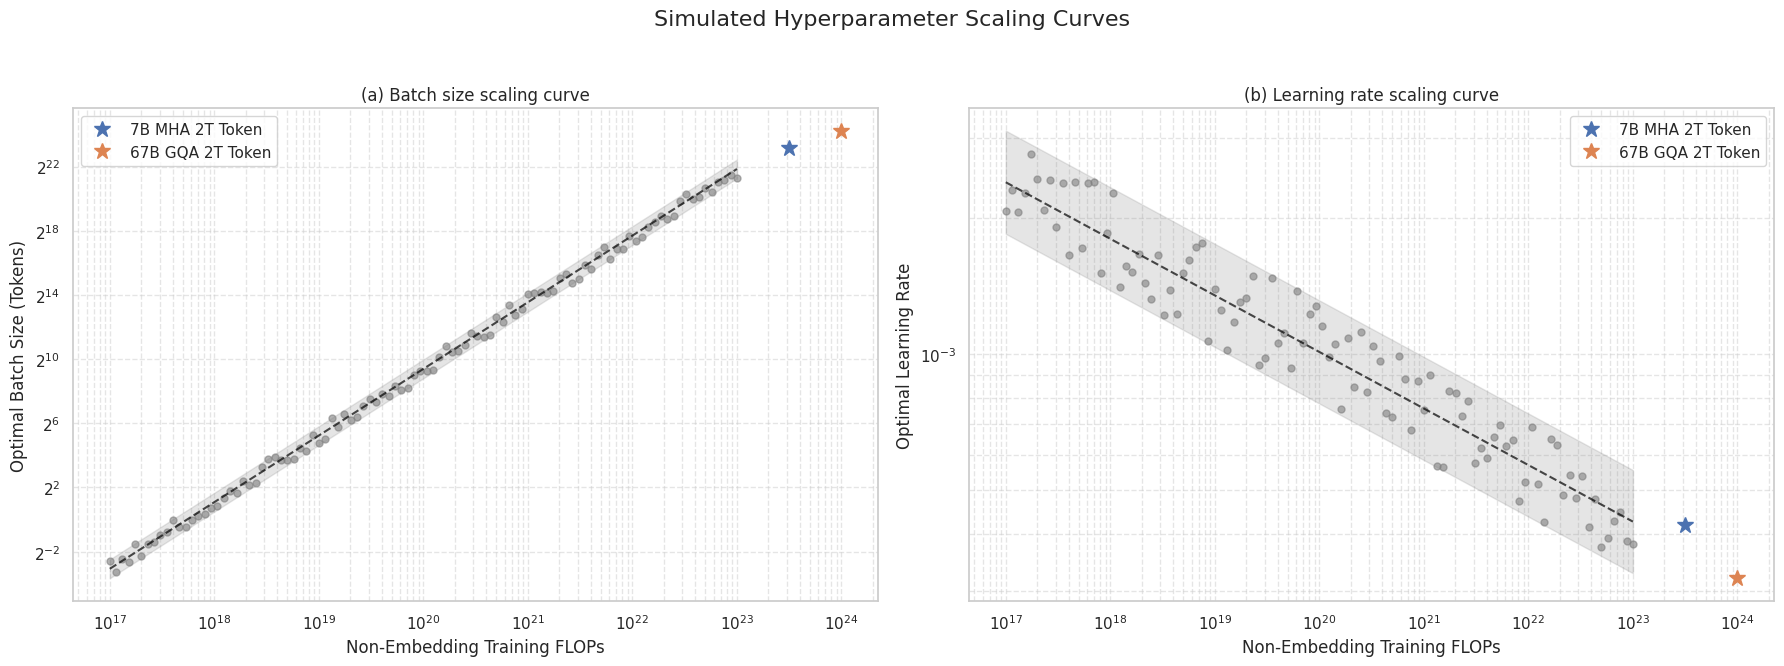

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Define the Scaling Law Relationships (approximated from the image)
# We'll define a power law: y = C * x^alpha
# On a log-log plot, this is a straight line: log(y) = alpha * log(x) + log(C)

# For Batch Size: BS = C1 * FLOPs^alpha1
# From the plot, as FLOPs go from 10^16 to 10^24 (8 orders of magnitude),
# Batch size (in tokens) goes from ~2^16 to ~2^26 (10 orders of magnitude in base 2).
# log2(BS) = alpha * log10(FLOPs) + const
# Let's estimate the exponent (slope on log-log plot)
alpha1 = (26 - 16) / (24 - 16)  # (y2-y1)/(x2-x1) for log-log
# Now find C1 using a point from the graph, e.g., (10^24 FLOPs, 2^26 tokens)
# 2^26 = C1 * (10^24)^alpha1 => C1 = 2^26 / (10^(24*alpha1))
C1 = (2**26) / (10**(24 * alpha1))

def get_optimal_batch_size(flops):
    return C1 * (flops ** alpha1)

# For Learning Rate: LR = C2 * FLOPs^alpha2
# From the plot, as FLOPs go from 10^16 to 10^24, LR goes from ~3e-3 to ~3e-4.
# This is a negative slope.
# Let's estimate the exponent
alpha2 = (np.log10(3e-4) - np.log10(3e-3)) / (24 - 16)
# Now find C2 using a point, e.g., (10^24 FLOPs, 3.2e-4 LR)
C2 = 3.2e-4 / (10**(24 * alpha2))

def get_optimal_lr(flops):
    return C2 * (flops ** alpha2)


# Part 2: Generate Simulated Data
# Create a range of FLOPs values on a log scale
flops_range = np.logspace(17, 23, 100)

# Calculate the "true" optimal values
true_bs = get_optimal_batch_size(flops_range)
true_lr = get_optimal_lr(flops_range)

# Generate scattered data points with some noise
# Add multiplicative noise in log space, which is common for scaling laws
noise_factor_bs = 1.5 # How much scatter for batch size
noise_factor_lr = 1.3 # How much scatter for learning rate
simulated_bs = true_bs * (noise_factor_bs ** (2 * (np.random.rand(len(flops_range)) - 0.5)))
simulated_lr = true_lr * (noise_factor_lr ** (2 * (np.random.rand(len(flops_range)) - 0.5)))

# Add specific points from the graph
flops_7b = 10**23.5 # Approximate position for 7B model
bs_7b = 9.2e6
lr_7b = 4.2e-4

flops_67b = 10**24 # Approximate position for 67B model
bs_67b = 19.7e6
lr_67b = 3.2e-4


# Part 3: Plot the Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Simulated Hyperparameter Scaling Curves', fontsize=16)

# --- Plot (a): Batch Size Scaling Curve ---
ax1.loglog(flops_range, simulated_bs, 'o', color='gray', alpha=0.6, markersize=5)
ax1.loglog(flops_range, true_bs, '--', color='black', alpha=0.7)
ax1.fill_between(flops_range, true_bs / noise_factor_bs, true_bs * noise_factor_bs, color='gray', alpha=0.2)
ax1.plot(flops_7b, bs_7b, '*', markersize=12, label='7B MLA 2T Token')
ax1.plot(flops_67b, bs_67b, '*', markersize=12, label='67B MLA 2T Token')

ax1.set_xlabel('Non-Embedding Training FLOPs')
ax1.set_ylabel('Optimal Batch Size (Tokens)')
ax1.set_title('(a) Batch size scaling curve')
ax1.set_yscale('log', base=2) # Set y-axis to log base 2
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend()

# --- Plot (b): Learning Rate Scaling Curve ---
ax2.loglog(flops_range, simulated_lr, 'o', color='gray', alpha=0.6, markersize=5)
ax2.loglog(flops_range, true_lr, '--', color='black', alpha=0.7)
ax2.fill_between(flops_range, true_lr / noise_factor_lr, true_lr * noise_factor_lr, color='gray', alpha=0.2)
ax2.plot(flops_7b, lr_7b, '*', markersize=12, label='7B MLA 2T Token')
ax2.plot(flops_67b, lr_67b, '*', markersize=12, label='67B MLA 2T Token')

ax2.set_xlabel('Non-Embedding Training FLOPs')
ax2.set_ylabel('Optimal Learning Rate')
ax2.set_title('(b) Learning rate scaling curve')
ax2.grid(True, which="both", ls="--", alpha=0.5)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The above is with simulated data. The real plots for Deepseek are shown below:

![image.png](assets/scaling-deepseek1.png)


![image-2.png](assets/scaling-deepseek2.png)

What you see here is the power of scaling laws. We basically trained a bunch of model variants with millions of parameters and scaled the learnings from those to multi-billion parameter sizes. Performing trial-and-error for hundreds of billions of parameters can be too costly, hence a most systematic approach is to do that analysis at a lower (and cheaper) scale and then using scaling laws to extrapolate.

Now that we have seen how to scale these, let's train our LLM on the FineWeb data to replicate a modern LLM.